In [1]:
from graphs import *
from arch import arch_model
from scipy.stats import mstats
from datetime import datetime as dt
import numpy as np
import plotly.graph_objs as go
import plotly.subplots as sp
from datetime import date as dt 
import pandas as pd

file_path= r'C:\Users\Clement\OneDrive\Documents\dashboard_data.xlsx'

In [2]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 600,
    'width': 800,
    'scale': 7  }} # Multiply title/legend/axis/canvas sizes by this factor

In [40]:
export=pd.read_excel(file_path,sheet_name="export_china")
fig=go.Figure()
fig.add_trace(go.Scatter(x=export['Date'],y=export['VALUE'],line_color='#00334E',name='Exports'))
    # add horizontal line
fig.update_layout(title={'text': "Exportations de la Chine (YoY)",'x': 0.5,'xanchor': 'center'},xaxis_title='Date',template="simple_white",
    legend=dict(x=0, y=-0.2, orientation='h', bgcolor='rgba(255, 255, 255, 0)'))
fig

In [41]:
def cpi_china(start_date='1990-01-01',end_date=dt.today()):
    """
    Function
    ---------- 
    Plot with plotly the consumer price index rate in the us
    https://fred.stlouisfed.org/series/CPALTT01CNM659N
    
    Parameters
    ----------
    start_date: start date of you're plot
    end_date: end date of you're plot
    
    Returns
    ------
    plot the CPI in US
    """
    cpi=web.DataReader('CPALTT01CNM659N','fred', start=start_date, end=end_date)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cpi.index, y=cpi['CPALTT01CNM659N'],line_color='#00334E', name='IPC'))
    fig.update_layout(title={'text': 'Indice des prix à la consommation','x': 0.5,'xanchor': 'center'},xaxis_title='Date',yaxis_title='IPC (%)',template="simple_white",
                      legend=dict(x=0, y=-0.2, orientation='h', bgcolor='rgba(255, 255, 255, 0)'))
    return fig

C:\Users\cm12c\AppData\Local\Temp\ipykernel_30280\770557007.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.1,1,1])


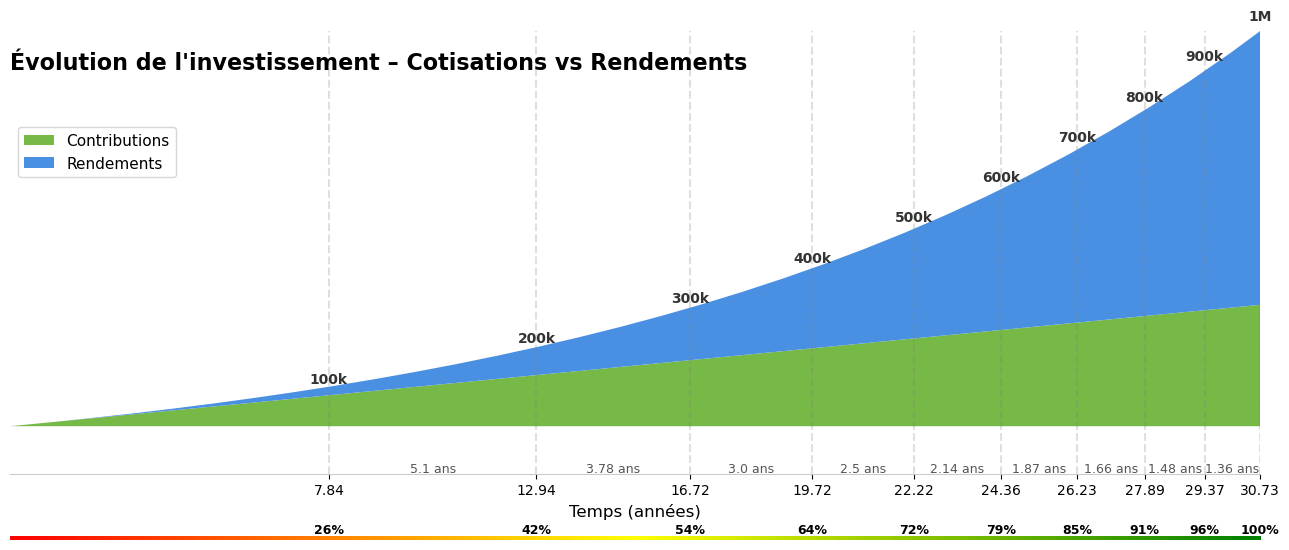

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paramètres
valeur_initiale = 0
contribution_annuelle = 10000
taux_de_rendement = 0.07
objectif = 1_000_000
jalons = np.arange(100_000, objectif + 1, 100_000)

# Simulation
annees = [0]
valeurs_totales = [valeur_initiale]
cotisations = [valeur_initiale]
rendements = [0]
t = 0

while valeurs_totales[-1] < objectif:
    t += 1
    new_cot = cotisations[-1] + contribution_annuelle
    new_val = valeurs_totales[-1] * (1 + taux_de_rendement) + contribution_annuelle
    new_rend = new_val - new_cot

    annees.append(t)
    cotisations.append(new_cot)
    valeurs_totales.append(new_val)
    rendements.append(new_rend)

# Interpolation jalons
jalons_annees = []
for j in jalons:
    for i in range(1, len(valeurs_totales)):
        if valeurs_totales[i] >= j:
            v1, v2 = valeurs_totales[i-1], valeurs_totales[i]
            t1, t2 = annees[i-1], annees[i]
            frac = (j - v1) / (v2 - v1)
            exact_year = t1 + frac * (t2 - t1)
            jalons_annees.append(round(exact_year, 2))
            break

# Progression en temps (%)
temps_total = jalons_annees[-1]
progres_temps = [round((a / temps_total) * 100, 0) for a in jalons_annees]  # arrondi 0 décimale
durées_intervalles = [round(jalons_annees[i] - jalons_annees[i-1], 2) for i in range(1, len(jalons_annees))]

# Conversion numpy
annees = np.array(annees)
cotisations = np.array(cotisations)
rendements = np.array(rendements)
valeurs_totales = np.array(valeurs_totales)

# Dégradé rouge->vert pour la barre de progression
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('RdYlGn', ['red', 'yellow', 'green'])
norm = mcolors.Normalize(vmin=0, vmax=100)

# Figure & axe
fig, ax = plt.subplots(figsize=(13, 6))

# Empilé (cotisations + rendements)
ax.stackplot(annees, cotisations, rendements,
             labels=["Contributions", "Rendements"],
             colors=["#76b947", "#4a90e2"])

# Supprimer grille
ax.grid(False)

# Supprimer bordures droite et haut
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Garder bordures bas et gauche mais en gris clair
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')

# Jalons et annotations :
for i, (j, a) in enumerate(zip(jalons, jalons_annees)):
    # Ligne verticale discrète
    ax.axvline(x=a, linestyle='--', color='gray', alpha=0.25)

    # Afficher valeur jalon (ex: "100k" sauf pour 1M)
    label = "1M" if j == objectif else f"{j//1000}k"
    ax.text(a, j * 1.02, label, ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # Durées entre jalons (sauf premier)
    if i > 0:
        milieu = (jalons_annees[i-1] + a) / 2
        y_pos = - (objectif * 0.05)
        ax.text(milieu, y_pos - (objectif * 0.04), f"{durées_intervalles[i-1]} ans",
                fontsize=9, ha='center', va='top', color='#555555')

# Ajuster limites y pour faire de la place sous x pour durée
ax.set_ylim(bottom=-objectif*0.12)

# Limites axes sans marge pour démarrer pile à (0,0)
ax.set_xlim(left=0, right=temps_total)
ax.set_ylim(bottom=-objectif*0.12, top=objectif)
ax.margins(x=0, y=0)

# Personnaliser ticks axe X : uniquement aux jalons
ax.set_xticks(jalons_annees)
ax.set_xticklabels([str(round(x,2)) for x in jalons_annees])

# Barre de progression intégrée (avec alignement corrigé)
bar_ax = inset_axes(ax, width="100%", height="8%", loc='lower left',
                    bbox_to_anchor=(0, -0.15, 1, 0.1),
                    bbox_transform=ax.transAxes, borderpad=0)

bar_ax.set_anchor('W')

gradient = np.linspace(0, 1, 256).reshape(1, -1)
bar_ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, temps_total, 0, 1])
bar_ax.set_xlim([0, temps_total])
bar_ax.set_ylim([0, 1])
bar_ax.axis('off')

# Ajouter le pourcentage d’avancement sur la barre de progression, au-dessus des jalons
for a, p in zip(jalons_annees, progres_temps):
    bar_ax.text(a, 1.1, f"{int(p)}%", ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# TITRE dans le graphique, aligné à gauche et en haut
ax.text(0, objectif * 0.95, "Évolution de l'investissement – Cotisations vs Rendements",
        fontsize=16, fontweight='bold', ha='left', va='top')

# Déplacer légende un peu plus bas (juste en dessous du titre, mais au-dessus du graphe)
ax.legend(loc="upper left", bbox_to_anchor=(0, 0.8), fontsize=11)

# Axes
ax.set_xlabel("Temps (années)", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)
# Ajustement layout
plt.tight_layout(rect=[0,0.1,1,1])

plt.show()


C:\Users\cm12c\AppData\Local\Temp\ipykernel_30280\3380581158.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.1,1,1])  # pour laisser place à la barre en bas


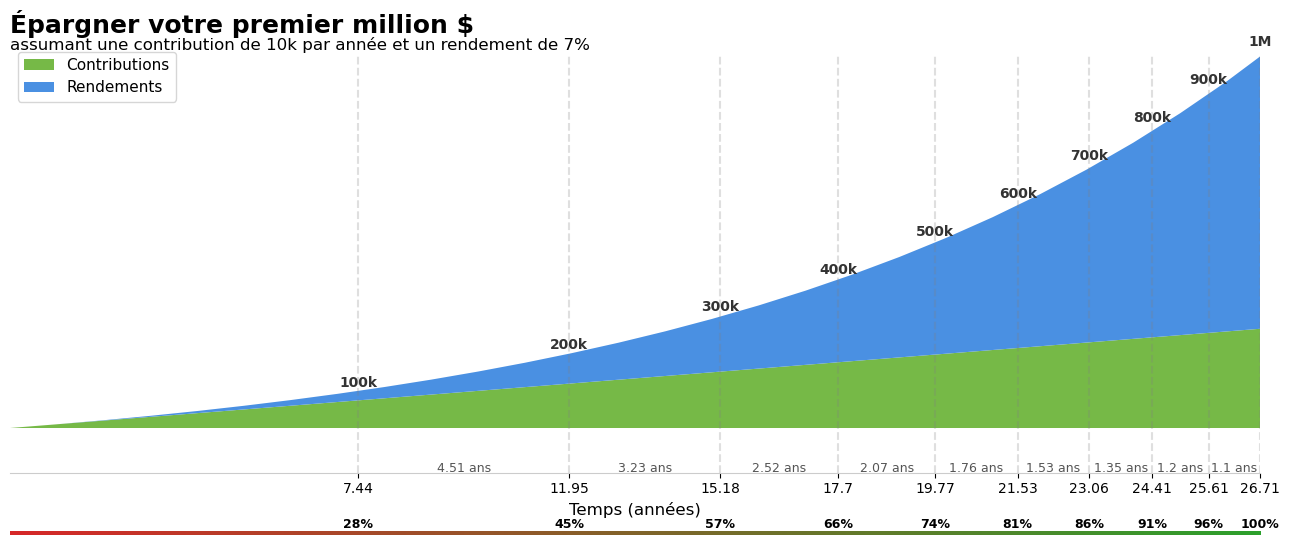

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paramètres
valeur_initiale = 0
contribution_annuelle = 10000
taux_de_rendement = 0.07
objectif = 1_000_000
jalons = np.arange(100_000, objectif + 1, 100_000)

# Simulation
annees = [0]
valeurs_totales = [valeur_initiale]
cotisations = [valeur_initiale]
rendements = [0]
t = 0

while valeurs_totales[-1] < objectif:
    t += 1
    new_cot = cotisations[-1] + contribution_annuelle
    new_val = valeurs_totales[-1] * (1 + taux_de_rendement) + contribution_annuelle
    new_rend = new_val - new_cot

    annees.append(t)
    cotisations.append(new_cot)
    valeurs_totales.append(new_val)
    rendements.append(new_rend)

# Interpolation jalons
jalons_annees = []
for j in jalons:
    for i in range(1, len(valeurs_totales)):
        if valeurs_totales[i] >= j:
            v1, v2 = valeurs_totales[i-1], valeurs_totales[i]
            t1, t2 = annees[i-1], annees[i]
            frac = (j - v1) / (v2 - v1)
            exact_year = t1 + frac * (t2 - t1)
            jalons_annees.append(round(exact_year, 2))
            break

# Progression en temps (%)
temps_total = jalons_annees[-1]
progres_temps = [round((a / temps_total) * 100, ) for a in jalons_annees]  # Arrondi 0 décimale
durées_intervalles = [round(jalons_annees[i] - jalons_annees[i-1], 2) for i in range(1, len(jalons_annees))]

# Conversion numpy
annees = np.array(annees)
cotisations = np.array(cotisations)
rendements = np.array(rendements)
valeurs_totales = np.array(valeurs_totales)

# Dégradé de couleur rouge -> vert
from matplotlib.colors import LinearSegmentedColormap
colors = ["#d62728", "#2ca02c"]  # rouge vers vert
cmap = LinearSegmentedColormap.from_list("RedGreen", colors)

# Figure & axe
fig, ax = plt.subplots(figsize=(13, 6))

# Empilé (cotisations + rendements)
ax.stackplot(annees, cotisations, rendements,
             labels=["Contributions", "Rendements"],
             colors=["#76b947", "#4a90e2"])

# Supprimer grille
ax.grid(False)

# Supprimer bordures droite et haut
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Garder bordures bas et gauche mais en gris clair
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')

# Supprimer affichage de l'axe Y et sa ligne
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)

# Jalons et annotations :
for i, (j, a) in enumerate(zip(jalons, jalons_annees)):
    # Ligne verticale discrète
    ax.axvline(x=a, linestyle='--', color='gray', alpha=0.25)

    # Afficher valeur jalon (ex: "100k" ou "1M") sur le graphique en haut de la ligne verticale
    label = f"{j//1000}k" if j < 1_000_000 else "1M"
    ax.text(a, j * 1.02, label, ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # Pour les durées entre jalons (sauf premier)
    if i > 0:
        milieu = (jalons_annees[i-1] + a) / 2
        y_pos = - (objectif * 0.05)
        ax.text(milieu, y_pos - (objectif * 0.04), f"{durées_intervalles[i-1]} ans",
                fontsize=9, ha='center', va='top', color='#555555')

# Ajuster limites y pour faire de la place sous x pour durée
ax.set_ylim(bottom = - objectif*0.12)

# Limites axes sans marge pour démarrer pile à (0,0)
ax.set_xlim(left=0, right=temps_total)
ax.set_ylim(bottom= - objectif*0.12, top=objectif)
ax.margins(x=0, y=0)

# Personnaliser ticks axe X : uniquement aux jalons
ax.set_xticks(jalons_annees)
ax.set_xticklabels([str(round(x,2)) for x in jalons_annees])

# Barre de progression intégrée (avec alignement corrigé, hauteur 8%)
bar_ax = inset_axes(ax, width="100%", height="10%", loc='lower left',
                    bbox_to_anchor=(0, -0.15, 1, 0.1),
                    bbox_transform=ax.transAxes, borderpad=0)

bar_ax.set_anchor('W')  # Ancrer à gauche

gradient = np.linspace(0, 1, 256).reshape(1, -1)
bar_ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, temps_total, 0, 1])
bar_ax.set_xlim([0, temps_total])
bar_ax.set_ylim([0, 1])
bar_ax.axis('off')

# Ajouter le pourcentage d’avancement sur la barre de progression, au-dessus des jalons
for a, p in zip(jalons_annees, progres_temps):
    bar_ax.text(a, 1.1, f"{p}%", ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# Légende (un peu plus bas)
ax.legend(loc="upper left", fontsize=11, bbox_to_anchor=(0, 1.03))

# TITRE en deux parties
ax.text(0, objectif*1.05, "Épargner votre premier million $",
        fontsize=18, fontweight='bold', ha='left', va='bottom')
ax.text(0, objectif*1.01, "assumant une contribution de 10k par année et un rendement de 7%",
        fontsize=12, ha='left', va='bottom')

# Titres axes
ax.set_xlabel("Temps (années)", fontsize=12)
ax.set_ylabel("")  # Sans label vertical

# Ajustement layout
plt.tight_layout(rect=[0,0.1,1,1])  # pour laisser place à la barre en bas

plt.show()


C:\Users\cm12c\AppData\Local\Temp\ipykernel_30280\3284056452.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0.1,1,1])  # pour laisser place à la barre en bas


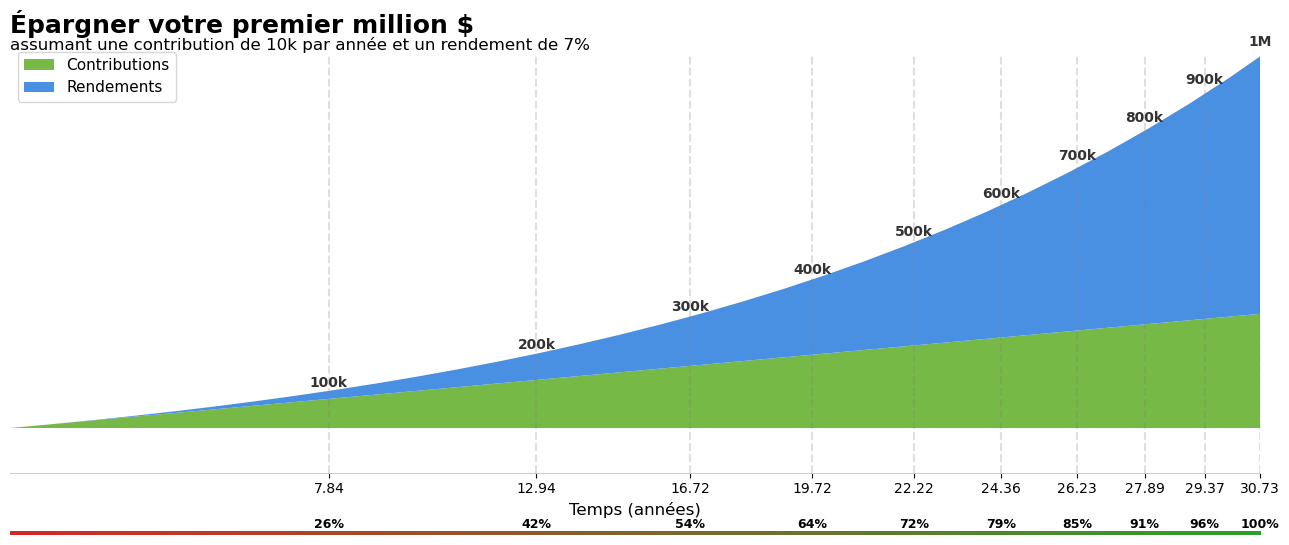

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paramètres
valeur_initiale = 0
contribution_annuelle = 10000
taux_de_rendement = 0.07
objectif = 1_000_000
jalons = np.arange(100_000, objectif + 1, 100_000)

# Simulation
annees = [0]
valeurs_totales = [valeur_initiale]
cotisations = [valeur_initiale]
rendements = [0]
t = 0

while valeurs_totales[-1] < objectif:
    t += 1
    new_cot = cotisations[-1] + contribution_annuelle
    new_val = valeurs_totales[-1] * (1 + taux_de_rendement) + contribution_annuelle
    new_rend = new_val - new_cot

    annees.append(t)
    cotisations.append(new_cot)
    valeurs_totales.append(new_val)
    rendements.append(new_rend)

# Interpolation jalons
jalons_annees = []
for j in jalons:
    for i in range(1, len(valeurs_totales)):
        if valeurs_totales[i] >= j:
            v1, v2 = valeurs_totales[i-1], valeurs_totales[i]
            t1, t2 = annees[i-1], annees[i]
            frac = (j - v1) / (v2 - v1)
            exact_year = t1 + frac * (t2 - t1)
            jalons_annees.append(round(exact_year, 2))
            break

# Progression en temps (%)
temps_total = jalons_annees[-1]
progres_temps = [round((a / temps_total) * 100, ) for a in jalons_annees]  # Arrondi 0 décimale
durées_intervalles = [round(jalons_annees[i] - jalons_annees[i-1], 2) for i in range(1, len(jalons_annees))]

# Conversion numpy
annees = np.array(annees)
cotisations = np.array(cotisations)
rendements = np.array(rendements)
valeurs_totales = np.array(valeurs_totales)

# Dégradé de couleur rouge -> vert
from matplotlib.colors import LinearSegmentedColormap
colors = ["#d62728", "#2ca02c"]  # rouge vers vert
cmap = LinearSegmentedColormap.from_list("RedGreen", colors)

# Figure & axe
fig, ax = plt.subplots(figsize=(13, 6))

# Empilé (cotisations + rendements)
ax.stackplot(annees, cotisations, rendements,
             labels=["Contributions", "Rendements"],
             colors=["#76b947", "#4a90e2"])

# Supprimer grille
ax.grid(False)

# Supprimer bordures droite et haut
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Garder bordures bas et gauche mais en gris clair
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')

# Supprimer affichage de l'axe Y et sa ligne
ax.get_yaxis().set_visible(False)
ax.spines['left'].set_visible(False)

# Jalons et annotations :
for i, (j, a) in enumerate(zip(jalons, jalons_annees)):
    # Ligne verticale discrète
    ax.axvline(x=a, linestyle='--', color='gray', alpha=0.25)

    # Afficher valeur jalon (ex: "100k" ou "1M") sur le graphique en haut de la ligne verticale
    label = f"{j//1000}k" if j < 1_000_000 else "1M"
    ax.text(a, j * 1.02, label, ha='center', va='bottom', fontsize=10, fontweight='bold', color='#333333')

    # Pour les durées entre jalons (sauf premier)
    #if i > 0:
        #milieu = (jalons_annees[i-1] + a) / 2
        #y_pos = - (objectif * 0.05)
        #ax.text(milieu, y_pos - (objectif * 0.04), f"{durées_intervalles[i-1]} ans",
                #fontsize=9, ha='center', va='top', color='#555555')

# Ajuster limites y pour faire de la place sous x pour durée
ax.set_ylim(bottom = - objectif*0.12)

# Limites axes sans marge pour démarrer pile à (0,0)
ax.set_xlim(left=0, right=temps_total)
ax.set_ylim(bottom= - objectif*0.12, top=objectif)
ax.margins(x=0, y=0)

# Personnaliser ticks axe X : uniquement aux jalons
ax.set_xticks(jalons_annees)
ax.set_xticklabels([str(round(x,2)) for x in jalons_annees])

# Barre de progression intégrée (avec alignement corrigé, hauteur 8%)
bar_ax = inset_axes(ax, width="100%", height="10%", loc='lower left',
                    bbox_to_anchor=(0, -0.15, 1, 0.1),
                    bbox_transform=ax.transAxes, borderpad=0)

bar_ax.set_anchor('W')  # Ancrer à gauche

gradient = np.linspace(0, 1, 256).reshape(1, -1)
bar_ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, temps_total, 0, 1])
bar_ax.set_xlim([0, temps_total])
bar_ax.set_ylim([0, 1])
bar_ax.axis('off')

# Ajouter le pourcentage d’avancement sur la barre de progression, au-dessus des jalons
for a, p in zip(jalons_annees, progres_temps):
    bar_ax.text(a, 1.1, f"{p}%", ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# Légende (un peu plus bas)
ax.legend(loc="upper left", fontsize=11, bbox_to_anchor=(0, 1.03))

# TITRE en deux parties
ax.text(0, objectif*1.05, "Épargner votre premier million $",
        fontsize=18, fontweight='bold', ha='left', va='bottom')
ax.text(0, objectif*1.01, "assumant une contribution de 10k par année et un rendement de 7%",
        fontsize=12, ha='left', va='bottom')

# Titres axes
ax.set_xlabel("Temps (années)", fontsize=12)
ax.set_ylabel("")  # Sans label vertical

# Ajustement layout
plt.tight_layout(rect=[0,0.1,1,1])  # pour laisser place à la barre en bas

plt.show()
